# Input data processing for the Clean Cooking Explorer (CCE)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from onsstove.onsstove import DataProcessor, RasterLayer

In [3]:
from decouple import config
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import rasterio

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val) if (val/total) > 0.01 else ''
    return my_format

## 1. Creating a project
First, we will create an instance of the `MCA` object that will be used to add raw datasets, process them and generate the required output datapackages for the CCE and OnSSTOVE. The `MCA` object accepts three optional argument `project_crs`, `cell_size` and `output_directory`. The first, sets the Coordinate reference System (crs) to use in the project, this means that all datasets will be reprojected to match such crs. The second, is used to define the desired cell size (i.e. width and height in meters) of the output datasets, which will be used to ensure that all output datasets match such cell size. The third, is simply used as the output folder in which all results will be writen, this parameter defaults to `output`.

In [ ]:
nepal = DataProcessor(project_crs=3857, cell_size=(1000, 1000))
nepal.output_directory = 'output' # Any of the attributes can be set at any time like this

## 2. Adding a PostgreSQL data base connection
Datasets can be read from any local path (or in some cases from urls) or from a PostgreSQL database. For the later, we would need to define the PostgreSQL connection, passing the database name `db`, the `POSTGRES_USER` and the `POSTGRES_KEY`.

In [ ]:
nepal.set_postgres(db='nepal', POSTGRES_USER=config('POSTGRES_USER'), POSTGRES_KEY=config('POSTGRES_KEY'))

## 3. Adding a mask layer
A vector layer can be added as a mask, which will be later used to mask/clip all output datasets to the layer boundaries. For this, we use the `add_mask_layer` method providing a `name` for the layer, a `layer_path` from where to read the data and in this case the `postgres` argument as `True` that will tell that the layer is found in the PostgreSQL database.

In [ ]:
nepal.add_mask_layer(category='Administrative', name='Country boundaries', 
                     layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Administrative boundaries\NPL_adm0_Nepal0.shp")

## 4. Adding data layers
Similarly, we can add data layers using the `add_layer` method. A layer `name`, `layer_path` and `postgres` conection also need to be provided (the `postgres` conection defaults to `False`). In addition, the following arguments can be passed:
* `category`: this is used to group all datasets into a category in the final output, e.g. `demand` or `supply`. 
* `layer_type`: thi argument is required with two possible options `raster` or `vector`, we should pass either one according to the dataset you are adding. 
* `distance`: the method to be used to calculate the distance raster for this layer. 
    * For `raster` layers, only `log` is available. This will create a logarithmic representation of the original raster. If this is not desired, we should pass `None` to the `distance` parameter (this is the defaul value), which will take the original raster as the distance raster.
    * For `vector` layers, two options are available `proximity` and `time_travel`. `proximity`, calculates a distance raster using the vectors (e.g. points, lines, polygons) as origin; the output raster will have the same dimentions and cell size as the `base_layer` (i.e. see below). `time_travel`, will need a friction raster (which can be added later) that will be used to calculate the least cost path to every cell taking the vectors as starting points.
* `normalization`: currently only `MinMax` normalization is available. This is used to normalize the distance rasters in a 0 to 1 range, which will be used later to calculate the CCE Demand, Supply and Clean Cooking potential indexes.
* `inverse`: we can specify if the scale of the ormalization need to be reversed, depending on the nature of the dataset.

In [ ]:
nepal.add_layer(category='demand', name='Population', layer_path='data/population_npl_2018-10-01.tif',
                layer_type='raster', normalization='MinMax', inverse=False, 
                distance='log', base_layer=False, resample='sum')

nepal.add_layer(category='demand', name='Education facilities', layer_path='places.education_facilities', postgres=True,
                layer_type='vector', normalization='MinMax', inverse=True, 
                distance='proximity')

nepal.layers['demand']['Population'].layer[np.isnan(nepal.layers['demand']['Population'].layer)] = 0
nepal.layers['demand']['Population'].save(os.path.join(nepal.output_directory, 'demand', 'Population'))

In [ ]:
nepal.add_layer(category='demand', name='Health facilities', layer_path='places.health_facilities', postgres=True,
                layer_type='vector', normalization='MinMax', inverse=True, 
                distance='proximity')

nepal.add_layer(category='demand', name='Commercial cooking', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Demand\Commercial cooking\Hotel_and_Restaurants_Nepal3.shp",
                layer_type='vector', normalization='MinMax', inverse=True, 
                distance='proximity')

nepal.add_layer(category='supply', name='Existent substations', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\Substations\Substations_Nepal_Updated.shp", 
                layer_type='vector', query='Substation == "Existing"', normalization='MinMax', inverse=True, 
                distance='proximity')

nepal.add_layer(category='supply', name='Planned substations', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\Substations\Substations_Nepal_Updated.shp", 
                layer_type='vector', query='Substation != "Existing"', normalization='MinMax', inverse=True, 
                distance='proximity')

nepal.add_layer(category='supply', name='Existent MV lines', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\MV-network\Nepal_DL0.shp",
                layer_type='vector', query='Status == "In Service"', normalization='MinMax', inverse=True, 
                distance='proximity')

nepal.add_layer(category='supply', name='Planned MV lines', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\MV-network\Nepal_DL0.shp",
                layer_type='vector', query='Status != "In Service"', 
                normalization='MinMax', inverse=True, 
                distance='proximity')

nepal.add_layer(category='supply', name='MG hydropower', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\MG-hydro\micro_hydropower.shp",
                layer_type='vector', 
                normalization='MinMax', inverse=True, 
                distance='proximity')

nepal.add_layer(category='other', name='Roads', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Roads\Road_Networks_of_Nepal_OSM0.shp",
                layer_type='vector', 
                normalization='MinMax', inverse=True, 
                distance='proximity')

In [ ]:
nepal.add_layer(category='supply', name='Existent HV lines', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\HV-network\Existing_transmission_lines.geojson",
                layer_type='vector', normalization='MinMax', inverse=True, 
                distance='proximity')

nepal.add_layer(category='supply', name='Planned HV lines', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\HV-network\Planned_transmission_lines.geojson",
                layer_type='vector', 
                normalization='MinMax', inverse=True, 
                distance='proximity')

In [ ]:
nepal.add_layer(category='supply', name='Biogas', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Global livestock\Biogas_potential.tif",
                layer_type='raster', normalization='MinMax', inverse=False, 
                resample='average')

## 5. Adding a base layer
A raster base layer is needed to make every output match its grid and extent. For this, two additional options need to be passed to the `add_layer` method:
* `base_layer`: if `True` the added layer will be considered as the base layer. 
* `resample`: this is the resampling method to be used when resampling this layer to the desired `cell_size` if a `cell_size` is provided.

In [ ]:
nepal.add_layer(category='supply', name='Biomass', layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Forest cover\Global Forest Cover Change (GFCC).tif",
                layer_type='raster', normalization='MinMax', inverse=False, base_layer=True, resample='nearest',
                distance='travel_time', distance_limit=5)

## 6. Adding a friction raster to a vector layer
After adding a vector layer, a raster friction layer can be associated to the vector layer in order to calculate a travel time dataset for it. To do so, we can call the vector layer we want by using the `layers` variable and calling the `category` and the `name` of the vector dataset between quotes and square brackets, and calling the `add_friction_raster` method. This method only needs the path of the raster `raster_path`.

In [ ]:
nepal.layers['supply']['Biomass'].add_friction_raster(raster=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Walking friction\2020_walking_only_friction_surface.geotiff",
                                                      resample='average')

In [ ]:
nepal.add_layer(category='supply', name='LPG dealers', layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\LPG\Nepal_Gas_12Jun2021_Final4.shp",
                postgres=False, layer_type='vector', normalization='MinMax', inverse=True, 
                distance='travel_time')

nepal.layers['supply']['LPG dealers'].add_friction_raster(raster=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Motorized friction\2020_motorized_friction_surface.geotiff",
                                                          resample='average')

## Relative Wealth Index

In [ ]:
nepal.add_layer(category='demand', name='Wealth', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Demand\Wealth Index\Wealth index 2011.tif",
                layer_type='raster', normalization='MinMax', inverse=False, resample='nearest')

In [ ]:
nepal.layers['demand']['Wealth'].layer[nepal.layers['demand']['Wealth'].layer<0] = np.nan
nepal.layers['demand']['Wealth'].meta['nodata'] = np.nan
nepal.layers['demand']['Wealth'].save(os.path.join(nepal.output_directory, 'demand', 'Wealth'))

In [ ]:
nepal.add_layer(category='other', name='GDP', 
                layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Demand\GDP\dryadfilled.tif",
                layer_type='raster', normalization='MinMax', inverse=False, resample='nearest')

nodata = nepal.layers['other']['GDP'].meta['nodata']
nepal.layers['other']['GDP'].layer[nepal.layers['other']['GDP'].layer==nodata] = np.nan
nepal.layers['other']['GDP'].meta['nodata'] = np.nan
nepal.layers['other']['GDP'].save(os.path.join(nepal.output_directory, 'other', 'GDP'))

## 7. Mask and reproject layers

In [ ]:
nepal.mask_layers(datasets={'supply': [
#     'Biomass', 'LPG dealers', 
                                       'Existent substations', 'Planned substations'],
#                             'other': ['GDP'],
                            'demand': [
#                                       'Population', 'Wealth',
                                      'Education facilities'
                                      ]
                           })

In [ ]:
nepal.reproject_layers(datasets='all')

In [ ]:
nepal.align_layers(datasets='all')

## 8. Calculate distance rasters and normalize

In [ ]:
nepal.get_distance_rasters(datasets='all')

In [ ]:
nepal.layers

## 9. Extract DHS datasets

In [ ]:
gdf = gpd.read_file(r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\Surveys\DHS Statcomplier\shps\sdr_subnational_data_dhs_2016.shp")
gdf.to_crs(nepal.project_crs, inplace=True)

In [ ]:
names = pd.read_csv(r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\Surveys\DHS Statcomplier\field_names.csv")
names = names.loc[names['SDRID'].str.contains('HCCKFLH') & 
                  names['Definition'].str.contains('Percentage of households whose main type of cooking fuel is ') &
                  ~names['SDRID'].str.contains('HCCKFLHCOL|HCCKFLHOTH'), 
                  ['SDRID', 'Definition']]
names['Name'] = names['Definition'].str.replace('Percentage of households whose main type of cooking fuel is ', '')
names['Name'] = names['Name'].str.replace('/','-')
names.loc[names['Name'].str.contains('LPG'), 'Name'] = 'LPG'

In [ ]:
folder = os.path.join(nepal.output_directory, 'other', 'GHS')
os.makedirs(folder, exist_ok=True)
for i, row in names.iterrows():
    gdf[[row['SDRID'], 'geometry']].to_file(os.path.join(folder, row['Name'] + '.geojson'), driver='GeoJSON')

## Create age structure datasets

In [ ]:
path = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Age and sex structure\npl_{}_{}_2020.tif"

for age_group in [[0, 1, 5, 10], 
                  range(15, 31, 5), range(35, 51, 5), 
                  range(55, 71, 5), range(75, 81, 5)
                 ]:
    rasters = []
    for sex in ['f', 'm']:
        for age in age_group:
            with rasterio.open(path.format(sex, age)) as src:
                band = src.read(1)
                meta = src.meta
                bounds = src.bounds
                band[band==meta['nodata']] = 0
                rasters.append(band)

    data = sum(rasters)
    data[data==0] = np.nan
    meta.update(nodata=np.nan)
    raster = RasterLayer('Age structure', 'age_{}-{}_2020.tif'.format(age_group[0], age_group[-1]))
    raster.layer = data
    raster.meta = meta
    raster.bounds = bounds
    raster.save('output/other/Age structure')
    raster.resample = 'sum'
    raster.reproject(3857, 'output/other/Age structure',cell_width=1000, cell_height=1000)

## 10. Save the model

In [ ]:
nepal.to_pickle('model.pkl')

## Plot some maps

In [ ]:
nepal = DataProcessor.read_model('Output/model.pkl')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from onsstove.layer import VectorLayer

In [ ]:
layer_path=r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Administrative boundaries\NPL_adm1_Province0.shp"
provinces = VectorLayer('Administrative', 'Provinces', layer_path)
provinces.reproject(3857, 'Output/Administrative')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
cmap = cm.get_cmap('viridis', 1)
nepal.mask_layer.style.update(color=cmap.colors[0], zorder=-1)
nepal.mask_layer.plot(ax=ax)
nepal.layers['demand']['Population'].name = 'Population count'
nepal.layers['demand']['Population'].plot(cumulative_count=(0.02, 0.98), ax=ax)
# provinces.plot(ax=ax, style=dict(zorder=2, linewidth=2, edgecolor='white', color=(0,0,0,0)))
# nepal.layers['demand']['Education facilities'].style.update(color='green', alpha=0.8, 
#                                                             linewidth=1, edgecolor='white')
# nepal.layers['demand']['Education facilities'].plot(ax=ax)
# nepal.layers['demand']['Health facilities'].style.update(color='red', alpha=0.8,
#                                                          linewidth=1, edgecolor='white')
# nepal.layers['demand']['Health facilities'].plot(ax=ax)
# lgnd = ax.legend(loc="upper right", prop={'size': 12})
# for handles in lgnd.legendHandles:
#     handles._sizes = [60]
plt.savefig('Output/Pop.png', dpi=150, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
cmap = cm.get_cmap('Spectral', 100)
nepal.mask_layer.style.update(color=cmap(3), zorder=-1)
nepal.mask_layer.plot(ax=ax)
nepal.layers['demand']['Wealth'].mask(nepal.mask_layer.layer, 'Output/demand/Wealth')
nepal.layers['demand']['Wealth'].name = 'International Wealth Index'
nepal.layers['demand']['Wealth'].plot(cmap='Spectral', ax=ax)
# provinces.plot(ax=ax, style=dict(zorder=2, linewidth=2, edgecolor='white', color=(0,0,0,0)))
plt.savefig('Output/Wealth.png', dpi=150, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
cmap = cm.get_cmap('viridis', 1)
# provinces.plot(ax=ax, style=dict(zorder=-1, linewidth=2, edgecolor='white', color='lightgray'))
# nepal.mask_layer.plot(ax=ax, style=dict(zorder=-1, linewidth=2, edgecolor='white', color='lightgray'))


mv_distance = RasterLayer('supply', 'MV-lines distance (km)')
mv_distance.meta = nepal.layers['supply']['Existent MV lines'].distance_raster.meta
mv_distance.bounds = nepal.layers['supply']['Planned MV lines'].distance_raster.bounds

mv_distance.layer = np.minimum(nepal.layers['supply']['Existent MV lines'].distance_raster.layer,
                               nepal.layers['supply']['Planned MV lines'].distance_raster.layer) / 1000

mv_distance.plot(ax=ax)

nepal.layers['supply']['Existent MV lines'].style = {}
nepal.layers['supply']['Existent MV lines'].name = 'Existing MV-lines'
nepal.layers['supply']['Existent MV lines'].style.update(color='orange', linewidth=1)
nepal.layers['supply']['Existent MV lines'].plot(ax=ax)

nepal.layers['supply']['Planned MV lines'].style = {}
nepal.layers['supply']['Planned MV lines'].name = 'Planned MV-lines'
nepal.layers['supply']['Planned MV lines'].style.update(color='red', linewidth=1)
nepal.layers['supply']['Planned MV lines'].plot(ax=ax)
# nepal.layers['supply']['Existent substations'].plot(ax=ax, style=dict(color='brown', linewidth=1, edgecolor='white',
#                                                                        markersize=60, zorder=2))

lgnd = ax.legend(loc=(0.75, 0.8), prop={'size': 12})
for handles in lgnd.legendHandles:
    handles._sizes = [60]
ax.set_axis_off()
plt.savefig('Output/MV_lines.png', dpi=150, bbox_inches='tight')

In [ ]:
from onsstove.layer import RasterLayer
fig, ax = plt.subplots(figsize=(16, 9))
cmap = cm.get_cmap('viridis', 1)
# provinces.plot(ax=ax, style=dict(zorder=-1, linewidth=2, edgecolor='white', color='lightgray'))
nepal.mask_layer.plot(ax=ax, style=dict(zorder=-1, linewidth=2, edgecolor='white', color='lightgray'))

substations = RasterLayer('supply', 'Substations distance (km)')
substations.meta = nepal.layers['supply']['Existent substations'].distance_raster.meta
substations.bounds = nepal.layers['supply']['Existent substations'].distance_raster.bounds

substations.layer = np.minimum(nepal.layers['supply']['Existent substations'].distance_raster.layer,
                               nepal.layers['supply']['Planned substations'].distance_raster.layer) / 1000

substations.plot(ax=ax)
nepal.layers['supply']['Existent substations'].plot(ax=ax, style=dict(color='darkblue', linewidth=1, edgecolor='white',
                                                                       markersize=40, zorder=2))
nepal.layers['supply']['Planned substations'].plot(ax=ax, style=dict(color='darkred', linewidth=1, edgecolor='white',
                                                                       markersize=40, zorder=2))

lgnd = ax.legend(loc=(0.75, 0.8), prop={'size': 12})
for handles in lgnd.legendHandles:
    handles._sizes = [60]
ax.set_axis_off()
plt.savefig('Output/Substations.png', dpi=150, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
cmap = cm.get_cmap('viridis', 1)
# provinces.plot(ax=ax, style=dict(zorder=-1, linewidth=2, edgecolor='white', color='lightgray'))
nepal.mask_layer.plot(ax=ax, style=dict(zorder=-1, linewidth=2, edgecolor='white', color='lightgray'))

nepal.layers['supply']['MG hydropower'].distance_raster.name = 'MG hydropower distance (km)'
nepal.layers['supply']['MG hydropower'].distance_raster.layer /= 1000
nepal.layers['supply']['MG hydropower'].distance_raster.plot(ax=ax)
nepal.layers['supply']['MG hydropower'].plot(ax=ax, style=dict(color='darkgreen', linewidth=1, edgecolor='white',
                                                                       markersize=40, zorder=2))
# nepal.layers['supply']['MG hydropower'].distance_raster.layer *= 1000

lgnd = ax.legend(loc=(0.75, 0.8), prop={'size': 12})
for handles in lgnd.legendHandles:
    handles._sizes = [60]
ax.set_axis_off()
plt.savefig('Output/Mini-grids.png', dpi=150, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
cmap = cm.get_cmap('viridis', 1)
# provinces.plot(ax=ax, style=dict(zorder=-1, linewidth=2, edgecolor='white', color='lightgray'))
nepal.mask_layer.plot(ax=ax, style=dict(zorder=-1, linewidth=2, edgecolor='white', color='lightgray'))

nepal.layers['supply']['LPG dealers'].distance_raster.name = 'LPG dealers - traveltime (hours)'
nepal.layers['supply']['LPG dealers'].distance_raster.plot(cumulative_count=(0.02, 0.98), ax=ax)
nepal.layers['supply']['LPG dealers'].plot(ax=ax, style=dict(color='darkorange', linewidth=1, 
                                                             edgecolor='white', alpha=0.8, markersize=40, zorder=2))

lgnd = ax.legend(loc=(0.75, 0.8), prop={'size': 12})
for handles in lgnd.legendHandles:
    handles._sizes = [60]
ax.set_axis_off()
plt.savefig('Output/LPG.png', dpi=150, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

nepal.layers['other']['Roads'].distance_raster.name = 'Roads distance (km)'
nepal.layers['other']['Roads'].distance_raster.layer /= 1000
nepal.layers['other']['Roads'].distance_raster.plot(ax=ax)
nepal.layers['other']['Roads'].distance_raster.layer *= 1000

nepal.layers['other']['Roads'].style = {}
nepal.layers['other']['Roads'].style.update(color='darkorange', linewidth=1)
nepal.layers['other']['Roads'].plot(ax=ax)

lgnd = ax.legend(loc=(0.75, 0.8), prop={'size': 12})
for handles in lgnd.legendHandles:
    handles._sizes = [60]
ax.set_axis_off()
plt.savefig('Output/Roads.png', dpi=150, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
nepal.layers['supply']['Biogas'].name = 'Biogas potential ($m^3/yr$)'
nepal.layers['supply']['Biogas'].plot(cmap='viridis', ax=ax)
nepal.mask_layer.plot(ax=ax, style=dict(zorder=2, linewidth=2, edgecolor='white', color=(0,0,0,0)))
plt.savefig('Output/Biogas.png', dpi=150, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
cmap = cm.get_cmap('Spectral', 100)
nepal.layers['other']['GDP'].name = 'GDP'
nepal.layers['other']['GDP'].mask(nepal.mask_layer.layer, 'Output/other/GDP')
nepal.layers['other']['GDP'].name = 'GDP per capita (PPP)'
nepal.layers['other']['GDP'].plot(cmap='Spectral', ax=ax, cumulative_count=(0.01, 0.99))
nepal.mask_layer.style.update(color=cmap(3), zorder=-1)
nepal.mask_layer.plot(ax=ax)
plt.savefig('Output/GDP.png', dpi=150, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

distance = RasterLayer('demand', 'Distance from facilities (km)')
distance.meta = nepal.layers['demand']['Education facilities'].distance_raster.meta
distance.bounds = nepal.layers['demand']['Education facilities'].distance_raster.bounds

distance.layer = np.minimum(nepal.layers['demand']['Education facilities'].distance_raster.layer,
                            nepal.layers['demand']['Health facilities'].distance_raster.layer)
distance.layer = np.minimum(distance.layer,
                            nepal.layers['demand']['Commercial cooking'].distance_raster.layer) / 1000

distance.plot(ax=ax)
nepal.layers['demand']['Health facilities'].plot(ax=ax, style=dict(color='red', linewidth=0.5, edgecolor='white',
                                                                       markersize=10, zorder=2, alpha=0.8))
nepal.layers['demand']['Education facilities'].plot(ax=ax, style=dict(color='green', linewidth=0.5, edgecolor='white',
                                                                       markersize=10, zorder=2, alpha=0.8))
nepal.layers['demand']['Commercial cooking'].plot(ax=ax, style=dict(color='orange', linewidth=0.5, edgecolor='white',
                                                                       markersize=10, zorder=2, alpha=0.8))

lgnd = ax.legend(loc=(0.75, 0.8), prop={'size': 12})
for handles in lgnd.legendHandles:
    handles._sizes = [60]
ax.set_axis_off()
plt.savefig('Output/Facilities.png', dpi=150, bbox_inches='tight')

In [ ]:
nepal.layers['demand']['Education facilities'].plot(style=dict(color='green', linewidth=0.5, edgecolor='white',
                                                               markersize=10, zorder=2, alpha=0.8))

## Scenarios

In [5]:
nepal = DataProcessor.read_model('Output/model.pkl')

### Policy-makers perspective
The Nepal Electricity Authority (NEA) is aiming at providing universal electricity access by 2022. Meanwhile, the government has as target to provide electrical cooking to every household by 2028. The first scenario assesses the potential for electrical cooking assuming mini-grids is still not viable to support it and takes the current electricity network and LPG dealers as supply options. The second scenarios assumes expansions in electricity sector and improvement of (current) mini-grids to supply electricity for cooking. By using this scenario, a policy maker can identify areas where a larger focus is needed for electricity expansion in order to reach the goals, but also how LPG can cover the potential shortfall. The third scenario is exclusively focused on LPG, taking into account supply points and potential transportation networks. The last scenario utilizes all available technologies and filters out areas with higher International Wealth Index to indicate where population that may not be able to invest in clean fuels are located.

#### Scenario 1
* The first scenario assesses the potential for electrical cooking assuming mini-grids is still not viable for supporting it, and takes the current electricity network and LPG dealers as supply options.
* In the demand section residential demand (population dataset), education and health facilities are included.
* International Wealth Index is also included in order to highlight the areas with lower economic activity.

In [119]:
scenario = 'Policy-makers 1'

nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = True
nepal.layers['supply']['LPG dealers'].distance_raster.inverse = True
nepal.layers['demand']['Wealth'].distance_raster.inverse = False


nepal.layers['supply']['Existent MV lines'].distance_raster.distance_limit = None
nepal.layers['supply']['LPG dealers'].distance_raster.distance_limit = None
nepal.layers['demand']['Wealth'].distance_raster.distance_limit = None

nepal.get_demand_index(datasets={'demand': ['Population', 'Health facilities',
                                            'Education facilities', 'Wealth']}, buffer=True)
nepal.get_supply_index(datasets={'supply': [
                                            'Existent MV lines',
                                            'LPG dealers'
                                           ]}, buffer=True)
nepal.get_clean_cooking_index(buffer=True)

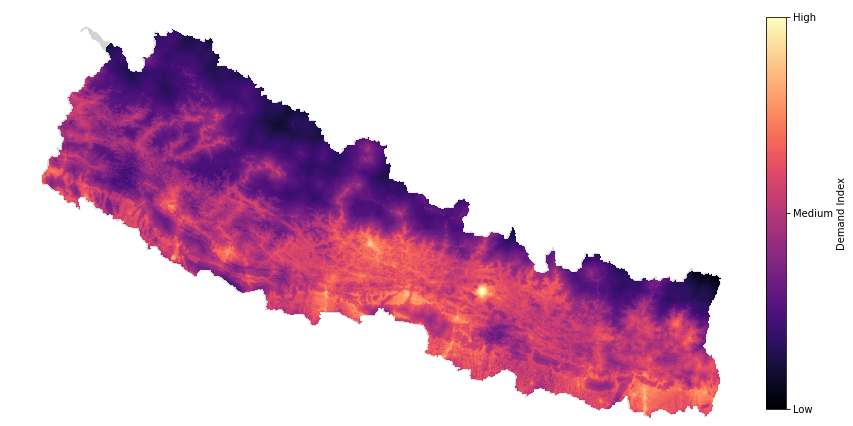

In [120]:
nepal.demand_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                        admin_layer=nepal.mask_layer.layer)

nepal.demand_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                            admin_layer=nepal.mask_layer.layer, dpi=150)

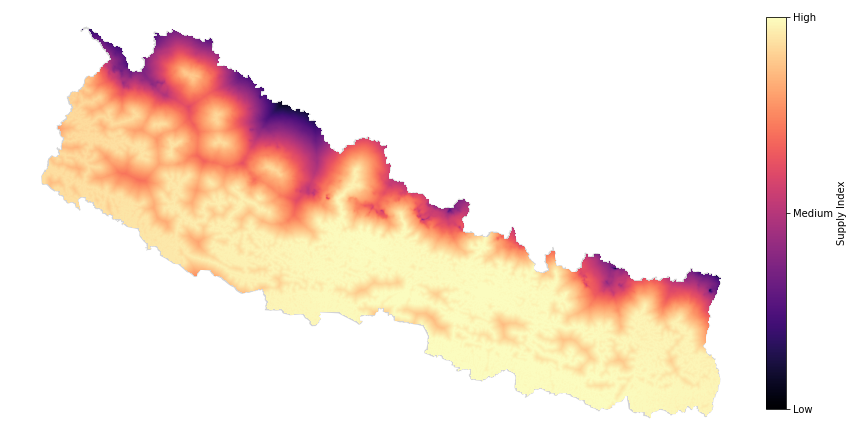

In [121]:
nepal.supply_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                        admin_layer=nepal.mask_layer.layer)

nepal.supply_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                            admin_layer=nepal.mask_layer.layer, dpi=150)

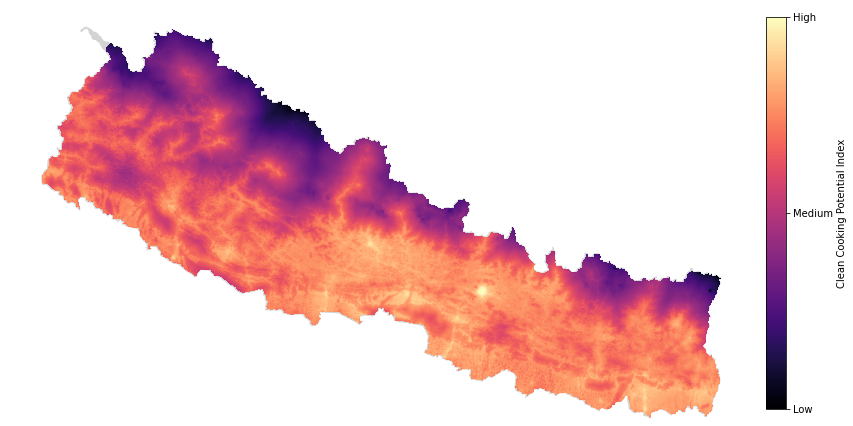

In [122]:
nepal.clean_cooking_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                               admin_layer=nepal.mask_layer.layer)

nepal.clean_cooking_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                   cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                   admin_layer=nepal.mask_layer.layer, dpi=150)

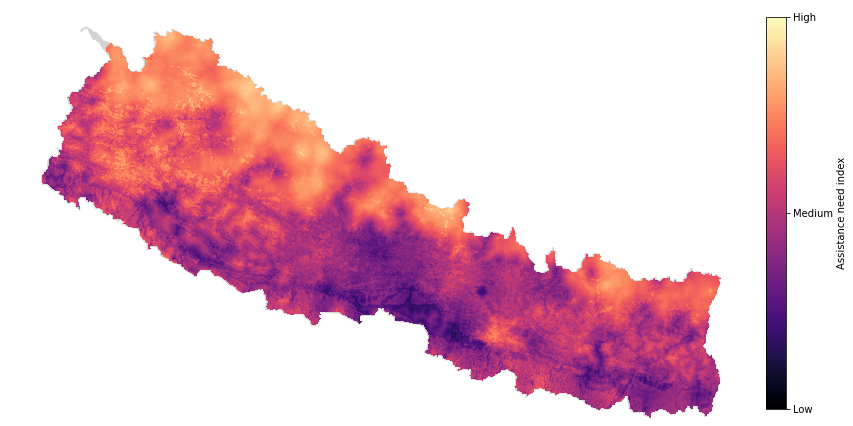

In [123]:
nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = False
nepal.layers['supply']['LPG dealers'].distance_raster.inverse = False
nepal.layers['demand']['Wealth'].distance_raster.inverse = True

nepal.get_assistance_need_index(datasets={'supply': ['Existent MV lines', 'LPG dealers'],
                                          'demand': ['Education facilities', 'Health facilities',
                                                     'Population', 'Wealth']}, buffer=True)
nepal.assistance_need_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                 admin_layer=nepal.mask_layer.layer)

nepal.assistance_need_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                     cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                     admin_layer=nepal.mask_layer.layer, dpi=150)

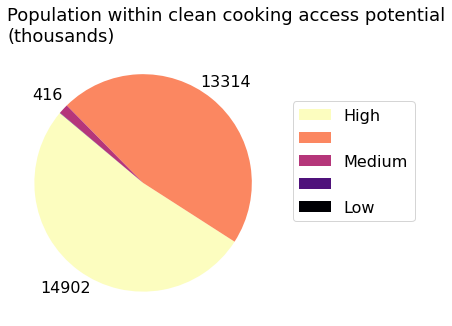

In [124]:
nepal.plot_share(index='Clean Cooking Potential Index', layer=('demand', 'Population'),
                 title='Population within clean cooking access potential', output_file=os.path.join(scenario, 'potential_pop.png'))

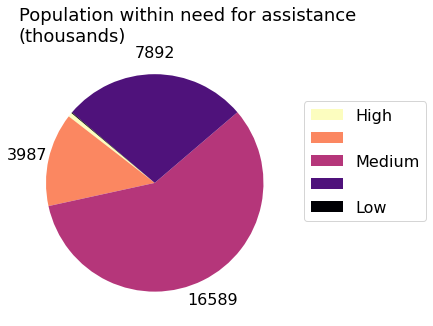

In [125]:
nepal.plot_share(index='Assistance Need Index', layer=('demand', 'Population'),
                 title='Population within need for assistance', output_file=os.path.join(scenario, 'assistance_pop.png'))

#### Scenario 2
* The second scenario assumes expansions in electricity sector (existing and planned MV-lines) and improvement of (current) mini-grids to supply electricity for cooking.
* In the demand section residential demand (population dataset), education and health facilities are included. 
* International Wealth Index is also included in order to highlight the areas with lower economic activity.

In [126]:
scenario = 'Policy-makers 2'

nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = True
nepal.layers['supply']['Planned MV lines'].distance_raster.inverse = True
nepal.layers['supply']['MG hydropower'].distance_raster.inverse = True
nepal.layers['demand']['Wealth'].distance_raster.inverse = False

nepal.layers['supply']['Existent MV lines'].distance_raster.distance_limit = None
nepal.layers['supply']['Planned MV lines'].distance_raster.distance_limit = None
nepal.layers['supply']['MG hydropower'].distance_raster.distance_limit = None

nepal.layers['supply']['Existent MV lines'].weight = 2
nepal.layers['supply']['Planned MV lines'].weight = 2
nepal.layers['supply']['MG hydropower'].weight = 1


nepal.get_demand_index(datasets={'demand': ['Population', 'Health facilities',
                                            'Education facilities', 'Wealth']}, buffer=True)
nepal.get_supply_index(datasets={'supply': ['Existent MV lines', 
                                            'Planned MV lines',
                                            'MG hydropower'
                                           ]}, buffer=True)
nepal.get_clean_cooking_index(buffer=True)

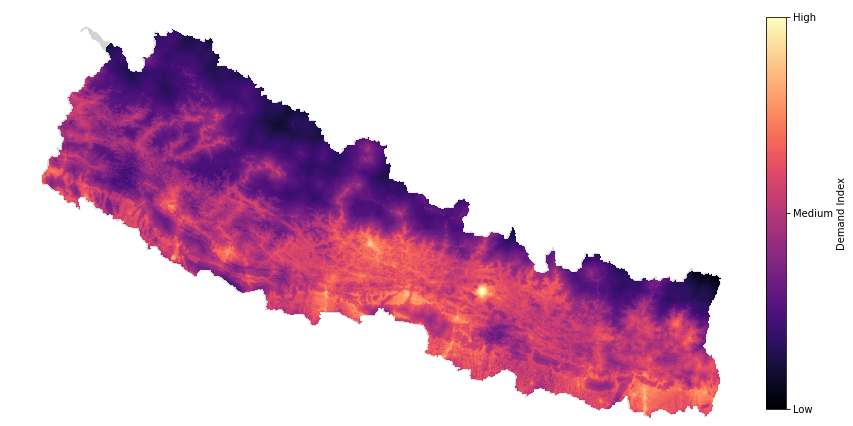

In [127]:
nepal.demand_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                        admin_layer=nepal.mask_layer.layer)

nepal.demand_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                            admin_layer=nepal.mask_layer.layer, dpi=150)

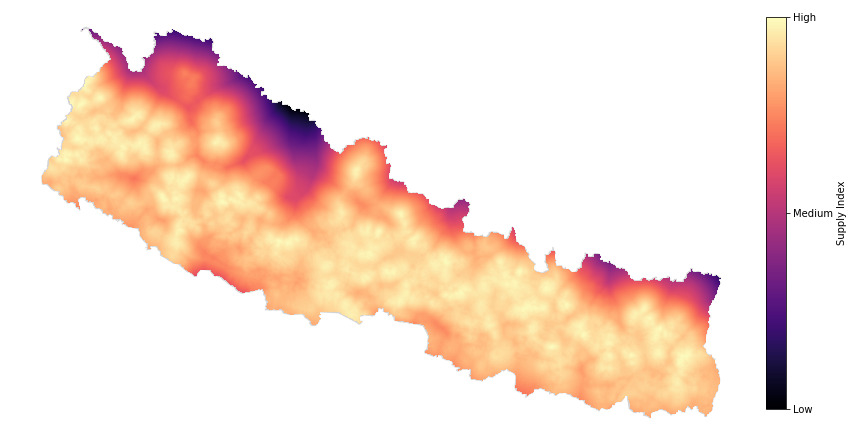

In [128]:
nepal.supply_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                        admin_layer=nepal.mask_layer.layer)

nepal.supply_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                            admin_layer=nepal.mask_layer.layer, dpi=150)

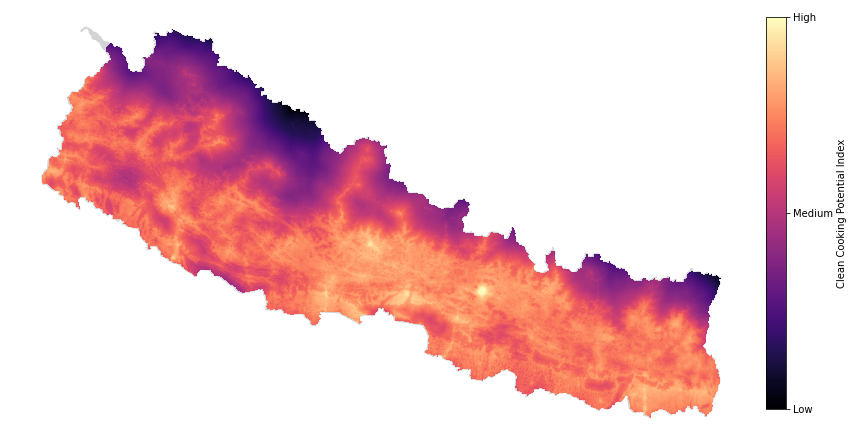

In [129]:
nepal.clean_cooking_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                               admin_layer=nepal.mask_layer.layer)

nepal.clean_cooking_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                   cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                   admin_layer=nepal.mask_layer.layer, dpi=150)

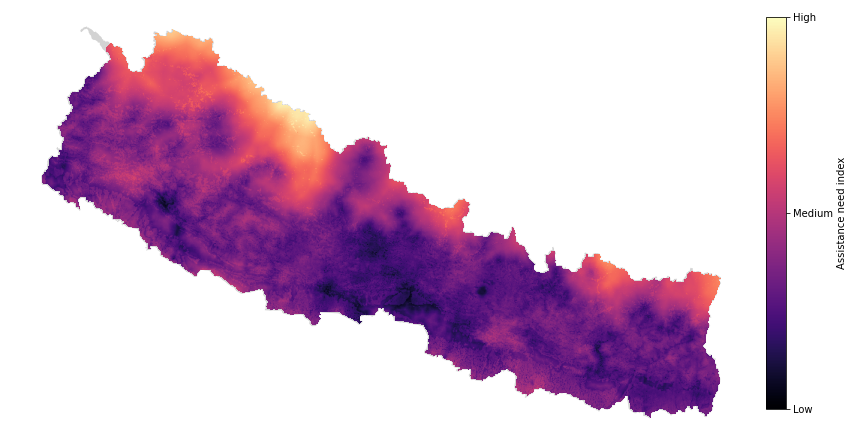

In [130]:
nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = False
nepal.layers['supply']['Planned MV lines'].distance_raster.inverse = False
nepal.layers['supply']['MG hydropower'].distance_raster.inverse = False
nepal.layers['demand']['Wealth'].distance_raster.inverse = True

nepal.get_assistance_need_index(datasets={'supply': ['Existent MV lines', 
                                                     'Planned MV lines',
                                                     'MG hydropower'],
                                          'demand': ['Education facilities', 'Health facilities',
                                                     'Population', 'Wealth']}, buffer=True)
nepal.assistance_need_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                 admin_layer=nepal.mask_layer.layer)

nepal.assistance_need_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                     cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                     admin_layer=nepal.mask_layer.layer, dpi=150)

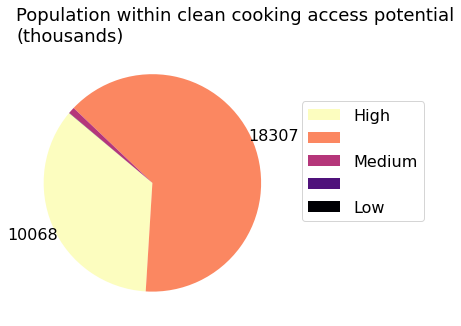

In [131]:
nepal.plot_share(index='Clean Cooking Potential Index', layer=('demand', 'Population'),
                 title='Population within clean cooking access potential', output_file=os.path.join(scenario, 'potential_pop.png'))

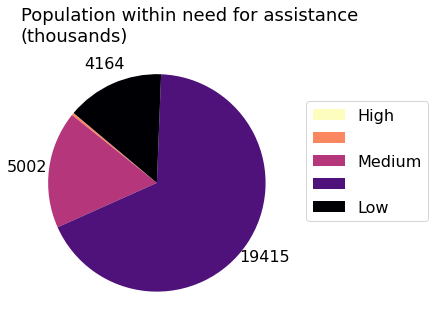

In [132]:
nepal.plot_share(index='Assistance Need Index', layer=('demand', 'Population'),
                 title='Population within need for assistance', output_file=os.path.join(scenario, 'assistance_pop.png'))

#### Scenario 3
* The third scenarios focuses on areas suitable for LPG use. On the supply side the (existing and planned MV-lines, weight 1), LPG supply points (weight 5) and the road network (weight 5) is used. All areas closer than 10 km to MV lines are filtered out, as is areas further away than 36 hours from the closest LPG supply point.
* In the demand section residential demand (population dataset), education and health facilities are included. All with equal weight of 1.
* International Wealth Index (weight 3) is also included in order to highlight the areas with lower economic activity.

In [133]:
scenario = 'Policy-makers 3'

nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = True
nepal.layers['supply']['LPG dealers'].distance_raster.inverse = True
nepal.layers['other']['Roads'].distance_raster.inverse = True
nepal.layers['demand']['Wealth'].distance_raster.inverse = False

nepal.layers['demand']['Population'].weight = 1
nepal.layers['demand']['Health facilities'].weight = 1
nepal.layers['demand']['Education facilities'].weight = 1
nepal.layers['demand']['Wealth'].weight = 3

nepal.layers['supply']['Existent MV lines'].weight = 1
nepal.layers['supply']['LPG dealers'].weight = 5
nepal.layers['other']['Roads'].weight = 5


nepal.layers['supply']['Existent MV lines'].distance_raster.distance_limit = lambda x: x > 10000
nepal.layers['supply']['LPG dealers'].distance_raster.distance_limit = lambda x: x < 36
nepal.layers['demand']['Wealth'].distance_raster.distance_limit = float('inf')

nepal.get_demand_index(datasets={'demand': ['Population', 'Health facilities',
                                            'Education facilities', 'Wealth']}, buffer=True)
nepal.get_supply_index(datasets={'supply': ['Existent MV lines', 
                                            'LPG dealers'],
                                 'other': ['Roads']}, buffer=True)
nepal.get_clean_cooking_index(buffer=True)

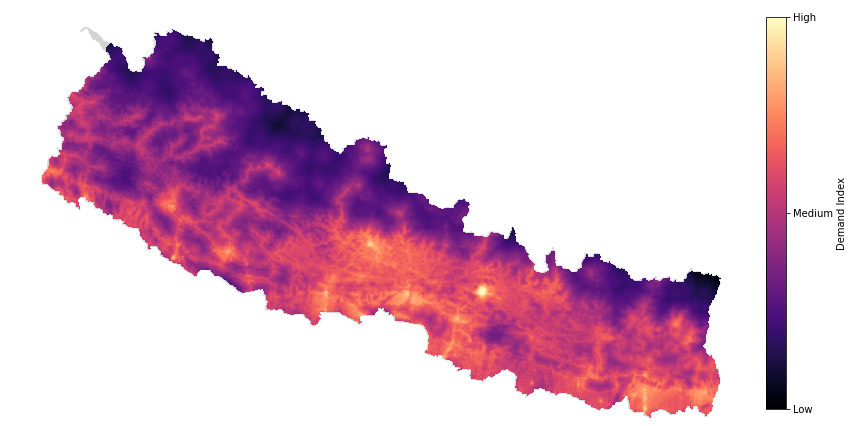

In [134]:
nepal.demand_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                        admin_layer=nepal.mask_layer.layer)

nepal.demand_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                            admin_layer=nepal.mask_layer.layer, dpi=150)

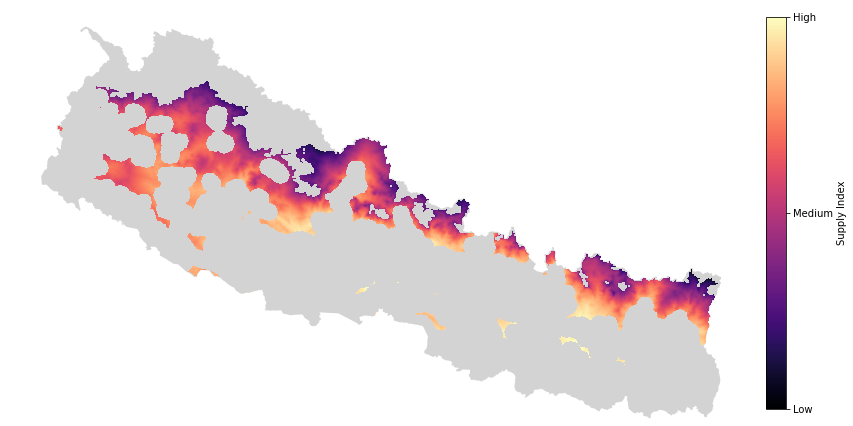

In [135]:
nepal.supply_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                        admin_layer=nepal.mask_layer.layer)

nepal.supply_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                            admin_layer=nepal.mask_layer.layer, dpi=150)

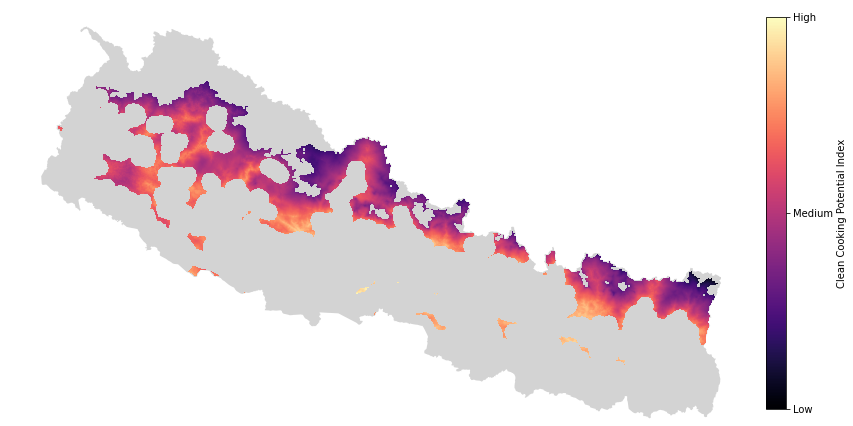

In [136]:
nepal.clean_cooking_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                               admin_layer=nepal.mask_layer.layer)

nepal.clean_cooking_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                   cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                   admin_layer=nepal.mask_layer.layer, dpi=150)

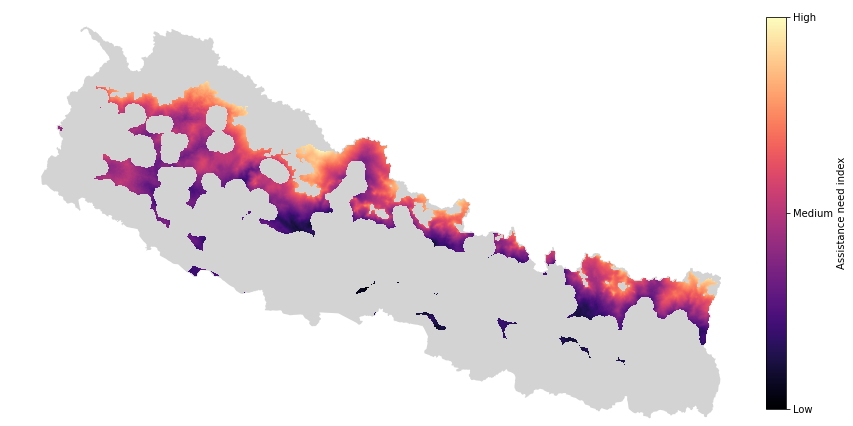

In [137]:
nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = False
nepal.layers['supply']['LPG dealers'].distance_raster.inverse = False
nepal.layers['other']['Roads'].distance_raster.inverse = False
nepal.layers['demand']['Wealth'].distance_raster.inverse = True

nepal.get_assistance_need_index(datasets={'supply': ['Existent MV lines', 'LPG dealers'],
                                          'demand': ['Education facilities', 'Health facilities',
                                                     'Population', 'Wealth'],
                                          'other': ['Roads']}, buffer=True)
nepal.assistance_need_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                 admin_layer=nepal.mask_layer.layer)

nepal.assistance_need_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                     cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                     admin_layer=nepal.mask_layer.layer, dpi=150)

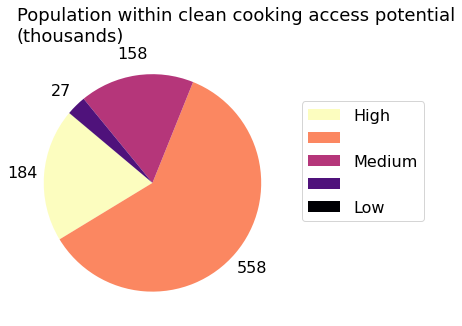

In [138]:
nepal.plot_share(index='Clean Cooking Potential Index', layer=('demand', 'Population'),
                 title='Population within clean cooking access potential', output_file=os.path.join(scenario, 'potential_pop.png'))

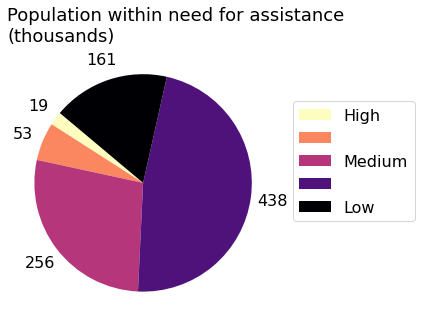

In [139]:
nepal.plot_share(index='Assistance Need Index', layer=('demand', 'Population'),
                 title='Population within need for assistance', output_file=os.path.join(scenario, 'assistance_pop.png'))

#### Scenario 4
* The fourth scenario focuses on areas suitable for ICS. On the supply side the (existing and planned MV-lines, weight 1), LPG supply points (weight 1) and the biogas potential (weight 1) are used to identify areas with low potential. All areas closer than 5 hours from LPG supply points and areas further away than 3 hours walking to biomass are filtered out.
* In the demand section residential demand (population dataset) is included (weight 1).
* International Wealth Index (weight 3) is also included. All areas with higher wealth index than 40 are filtered out.

In [140]:
scenario = 'Policy-makers 4'

nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = True
nepal.layers['supply']['LPG dealers'].distance_raster.inverse = True
nepal.layers['supply']['Biogas'].distance_raster.inverse = False
nepal.layers['demand']['Wealth'].distance_raster.inverse = False

nepal.layers['supply']['Existent MV lines'].weight = 1
nepal.layers['supply']['Biomass'].weight = 0
nepal.layers['supply']['LPG dealers'].weight = 1
nepal.layers['supply']['Biogas'].weight = 1
nepal.layers['demand']['Population'].weight = 1
nepal.layers['demand']['Wealth'].weight = 3

nepal.layers['supply']['Existent MV lines'].distance_raster.distance_limit = float('inf')
nepal.layers['supply']['LPG dealers'].distance_raster.distance_limit = lambda x: x > 5
nepal.layers['demand']['Wealth'].distance_raster.distance_limit = lambda x: x < 40
nepal.layers['supply']['Biomass'].distance_raster.distance_limit = lambda x: x < 3

nepal.get_demand_index(datasets={'demand': ['Population', 'Wealth']}, buffer=True)
nepal.get_supply_index(datasets={'supply': ['Existent MV lines', 
                                            'LPG dealers',
                                            'Biogas', 'Biomass']},
                                 buffer=True)
nepal.get_clean_cooking_index(buffer=True)

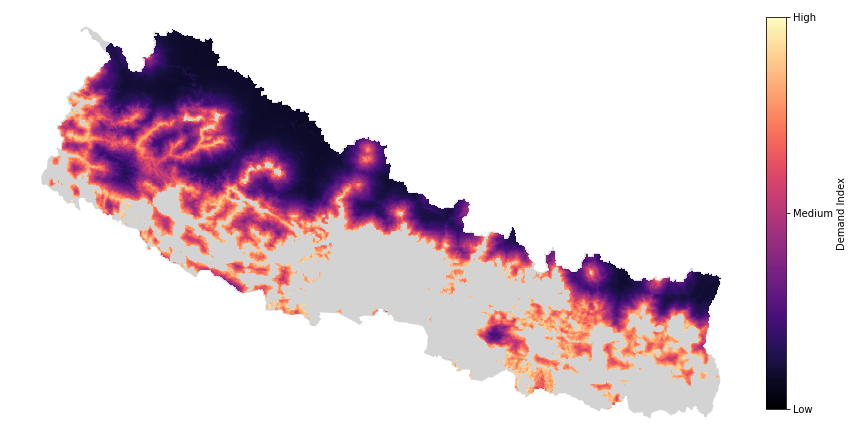

In [141]:
nepal.demand_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                        admin_layer=nepal.mask_layer.layer)

nepal.demand_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                            admin_layer=nepal.mask_layer.layer, dpi=150)

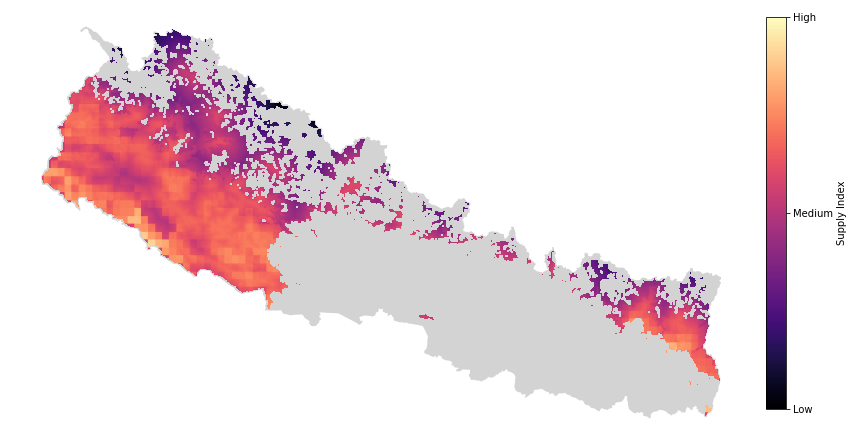

In [142]:
nepal.supply_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                        admin_layer=nepal.mask_layer.layer)

nepal.supply_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                            admin_layer=nepal.mask_layer.layer, dpi=150)

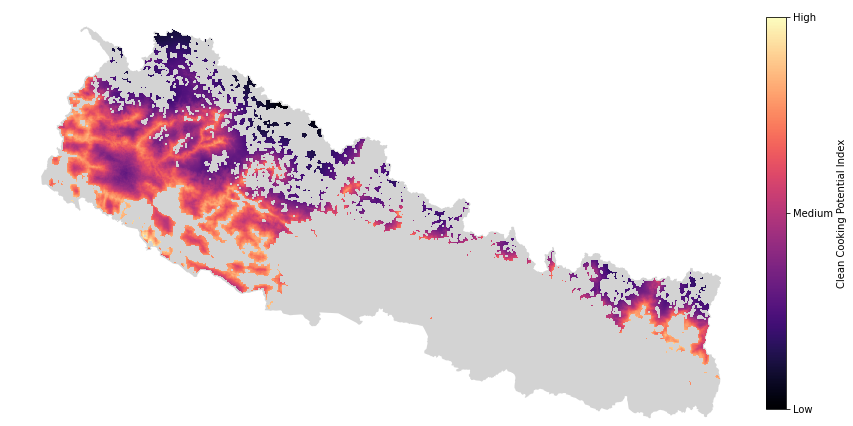

In [143]:
nepal.clean_cooking_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                               admin_layer=nepal.mask_layer.layer)

nepal.clean_cooking_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                   cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                   admin_layer=nepal.mask_layer.layer, dpi=150)

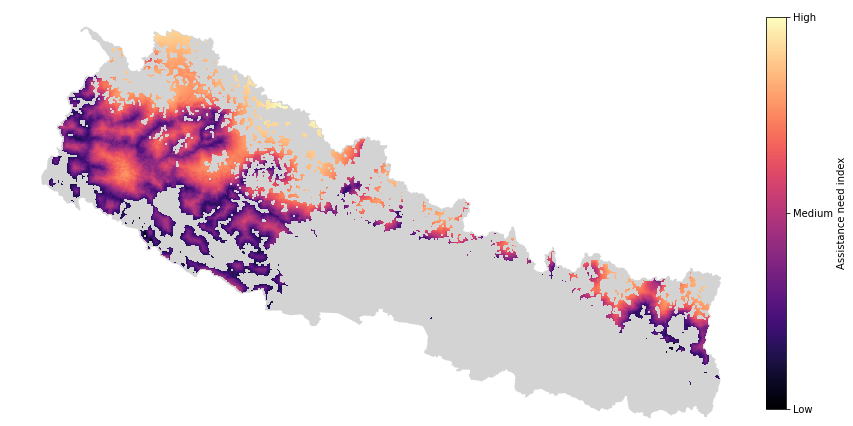

In [144]:
nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = False
nepal.layers['supply']['LPG dealers'].distance_raster.inverse = False
nepal.layers['supply']['Biogas'].distance_raster.inverse = True
nepal.layers['demand']['Wealth'].distance_raster.inverse = True

nepal.get_assistance_need_index(datasets={'supply': ['Existent MV lines', 'LPG dealers', 'Biogas', 'Biomass'],
                                          'demand': ['Population', 'Wealth']}, buffer=True)
nepal.assistance_need_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                 admin_layer=nepal.mask_layer.layer)

nepal.assistance_need_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                     cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                     admin_layer=nepal.mask_layer.layer, dpi=150)

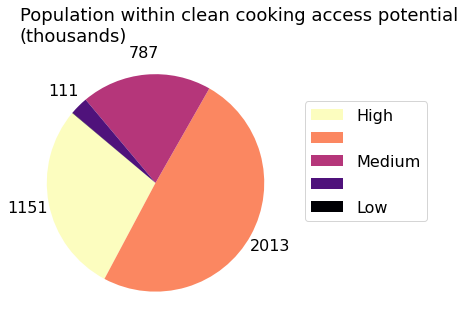

In [145]:
nepal.plot_share(index='Clean Cooking Potential Index', layer=('demand', 'Population'),
                 title='Population within clean cooking access potential', output_file=os.path.join(scenario, 'potential_pop.png'))

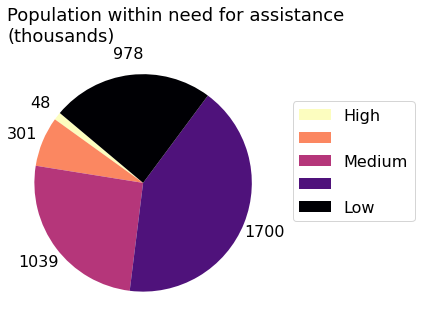

In [146]:
nepal.plot_share(index='Assistance Need Index', layer=('demand', 'Population'),
                 title='Population within need for assistance', output_file=os.path.join(scenario, 'assistance_pop.png'))

#### Scenario 5 (Biogas)

In [147]:
scenario = 'Policy-makers 5 (Biogas)'

nepal.layers['supply']['Biogas'].distance_raster.inverse = False
nepal.layers['demand']['Wealth'].distance_raster.inverse = False

nepal.layers['demand']['Wealth'].distance_raster.distance_limit = lambda x: x < 40

nepal.get_demand_index(datasets={'demand': ['Population', 'Wealth']}, buffer=True)
nepal.get_supply_index(datasets={'supply': ['Biogas']}, buffer=True)
nepal.get_clean_cooking_index(buffer=True)

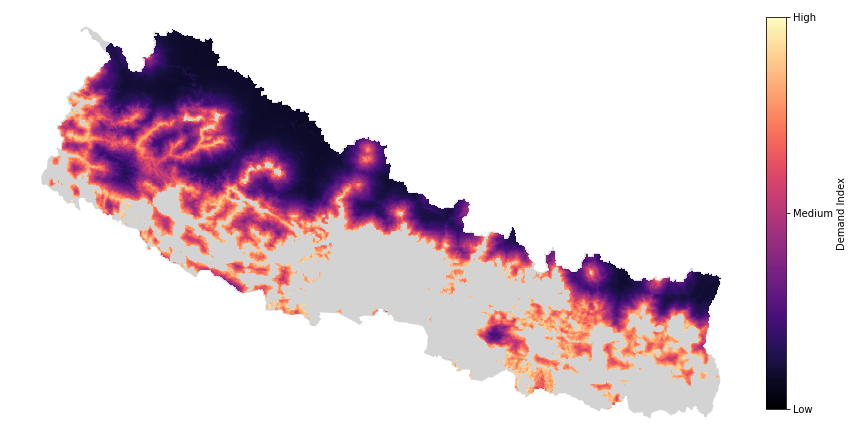

In [148]:
nepal.demand_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                        admin_layer=nepal.mask_layer.layer)

nepal.demand_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                            admin_layer=nepal.mask_layer.layer, dpi=150)

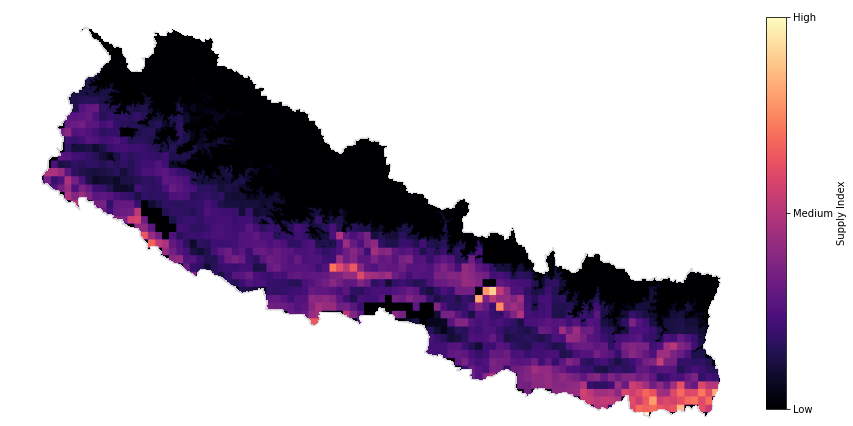

In [149]:
nepal.supply_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                        admin_layer=nepal.mask_layer.layer)

nepal.supply_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                            admin_layer=nepal.mask_layer.layer, dpi=150)

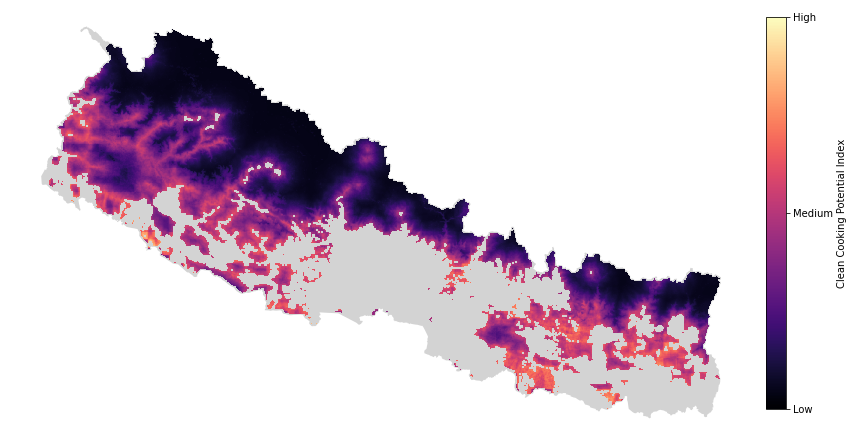

In [150]:
nepal.clean_cooking_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                               admin_layer=nepal.mask_layer.layer)

nepal.clean_cooking_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                   cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                   admin_layer=nepal.mask_layer.layer, dpi=150)

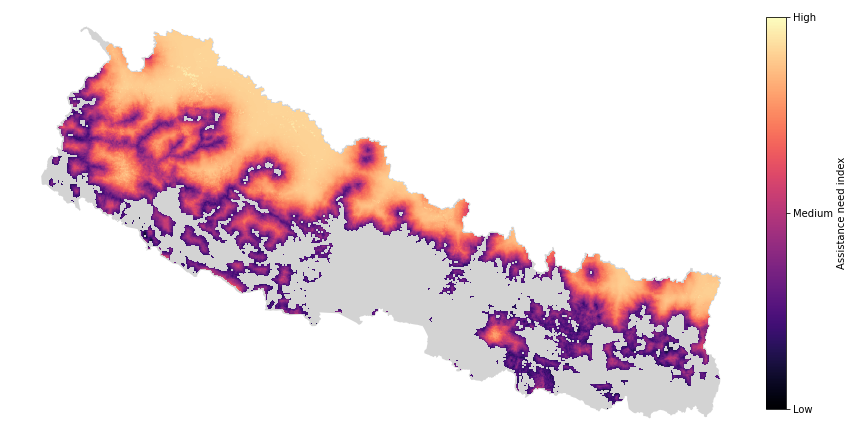

In [151]:
nepal.layers['supply']['Biogas'].distance_raster.inverse = True
nepal.layers['demand']['Wealth'].distance_raster.inverse = True

nepal.get_assistance_need_index(datasets={'supply': ['Biogas'],
                                          'demand': ['Population', 'Wealth']}, buffer=True)
nepal.assistance_need_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                 admin_layer=nepal.mask_layer.layer)

nepal.assistance_need_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                     cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                     admin_layer=nepal.mask_layer.layer, dpi=150)

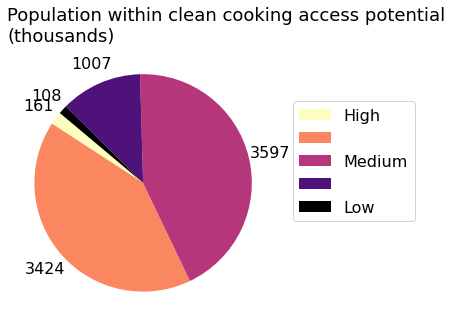

In [152]:
nepal.plot_share(index='Clean Cooking Potential Index', layer=('demand', 'Population'),
                 title='Population within clean cooking access potential', output_file=os.path.join(scenario, 'potential_pop.png'))

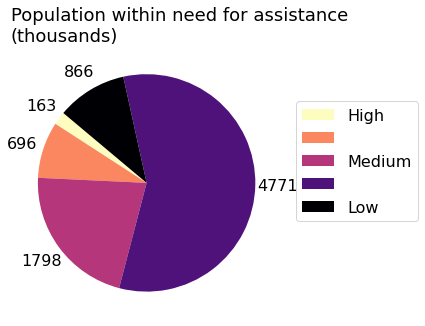

In [153]:
nepal.plot_share(index='Assistance Need Index', layer=('demand', 'Population'),
                 title='Population within need for assistance', output_file=os.path.join(scenario, 'assistance_pop.png'))

### Investors perspective
The tool can help investors in different technologies identify high priority areas by taking into account demand, current supply and ability to pay. By using these factors, the supply index and clean cooking potential index can be visualized i.e. where there are gaps in the supply and clean cooking is most viable. Scenarios are available for electricity and LPG.
#### Scenario 1
* The first scenario assesses the potential for electrical cooking assuming mini-grids is still not viable to support it and takes the current electricity network  as supply option.
* In the demand section residential demand (population dataset), education and health facilities as well as commercial cooking are included.
* GDP and International Wealth Index are also included in order to highlight the areas with higher economic activity.

In [162]:
scenario = 'Investors 1'

nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = True
nepal.layers['demand']['Wealth'].distance_raster.inverse = False
nepal.layers['other']['GDP'].distance_raster.inverse = False

nepal.layers['supply']['Existent MV lines'].distance_raster.distance_limit = lambda x: x < 30000
nepal.layers['demand']['Education facilities'].distance_raster.distance_limit = None
nepal.layers['demand']['Health facilities'].distance_raster.distance_limit = None
nepal.layers['demand']['Commercial cooking'].distance_raster.distance_limit = None
nepal.layers['demand']['Wealth'].distance_raster.distance_limit = lambda x: x > 40

nepal.layers['supply']['Existent MV lines'].weight = 1
nepal.layers['demand']['Population'].weight = 2
nepal.layers['demand']['Education facilities'].weight = 1
nepal.layers['demand']['Health facilities'].weight = 1
nepal.layers['demand']['Commercial cooking'].weight = 1
nepal.layers['demand']['Wealth'].weight = 3
nepal.layers['other']['GDP'].weight = 1

nepal.get_demand_index(datasets={'demand': ['Population', 'Education facilities', 'Health facilities', 
                                            'Commercial cooking', 'Wealth'],
                                 'other': ['GDP']}, buffer=True)
nepal.get_supply_index(datasets={'supply': ['Existent MV lines']}, buffer=True)
nepal.get_clean_cooking_index(buffer=True)

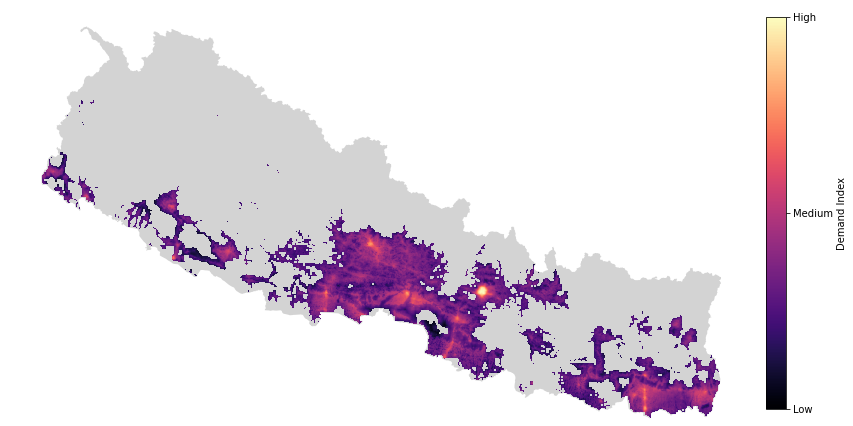

In [163]:
nepal.demand_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                        admin_layer=nepal.mask_layer.layer)

nepal.demand_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                            admin_layer=nepal.mask_layer.layer, dpi=150)

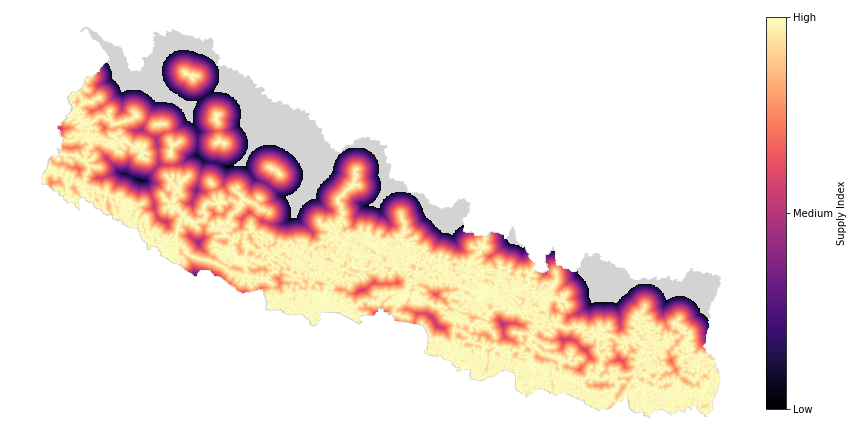

In [164]:
nepal.supply_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                        admin_layer=nepal.mask_layer.layer)

nepal.supply_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                            admin_layer=nepal.mask_layer.layer, dpi=150)

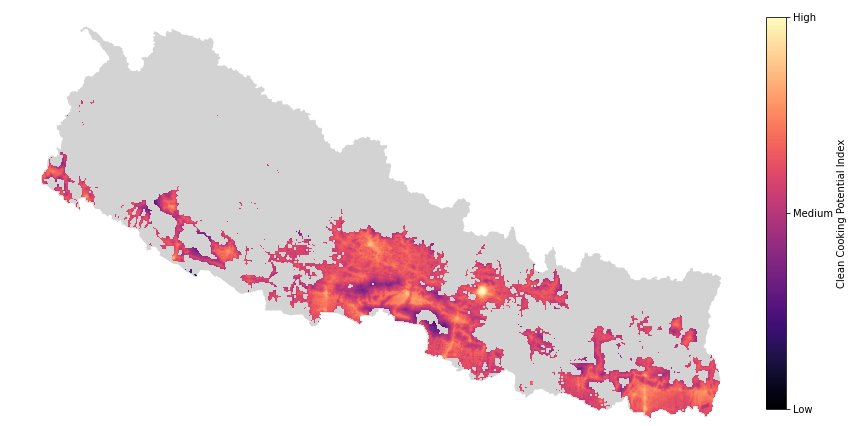

In [165]:
nepal.clean_cooking_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                               admin_layer=nepal.mask_layer.layer)

nepal.clean_cooking_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                   cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                   admin_layer=nepal.mask_layer.layer, dpi=150)

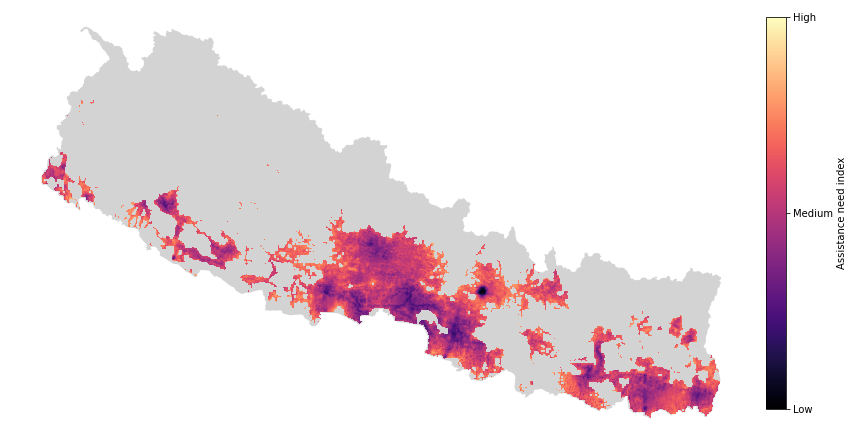

In [167]:
nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = False
nepal.layers['demand']['Wealth'].distance_raster.inverse = True
nepal.layers['other']['GDP'].distance_raster.inverse = True

nepal.get_assistance_need_index(datasets={'supply': ['Existent MV lines'],
                                          'demand': ['Population', 'Wealth', 'Education facilities', 
                                                     'Health facilities', 'Commercial cooking'],
                                          'other': ['GDP']}, buffer=True)

nepal.assistance_need_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                 admin_layer=nepal.mask_layer.layer)

nepal.assistance_need_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                     cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                     admin_layer=nepal.mask_layer.layer, dpi=150)

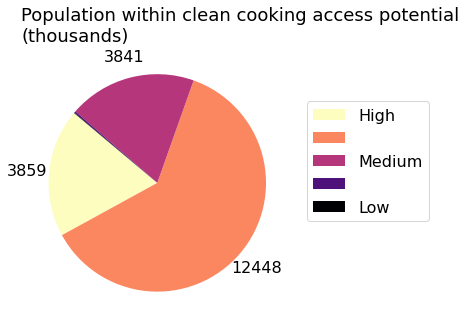

In [168]:
nepal.plot_share(index='Clean Cooking Potential Index', layer=('demand', 'Population'),
                 title='Population within clean cooking access potential', output_file=os.path.join(scenario, 'potential_pop.png'))

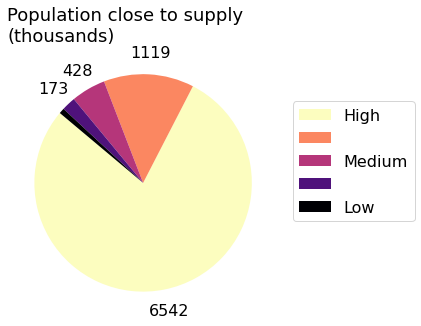

In [169]:
nepal.plot_share(index='Supply Index', layer=('demand', 'Population'),
                 title='Population close to supply', output_file=os.path.join(scenario, 'supply_pop.png'))

#### Scenario 2
* The second scenarios focuses on investors interested in LPG. On the supply side LPG supply points and the road network is included.
* In the demand section residential demand (population dataset), education and health facilities are included.
* GDP and International Wealth Index are also included in order to highlight the areas with lower economic activity.

In [170]:
scenario = 'Investors 2'

nepal.layers['supply']['LPG dealers'].distance_raster.inverse = True
nepal.layers['demand']['Wealth'].distance_raster.inverse = False
nepal.layers['other']['GDP'].distance_raster.inverse = False
nepal.layers['other']['Roads'].distance_raster.inverse = True

nepal.layers['supply']['LPG dealers'].distance_raster.distance_limit = lambda x: x < 36
nepal.layers['other']['Roads'].distance_raster.distance_limit = None
nepal.layers['demand']['Education facilities'].distance_raster.distance_limit = None
nepal.layers['demand']['Health facilities'].distance_raster.distance_limit = None
nepal.layers['demand']['Wealth'].distance_raster.distance_limit = lambda x: x > 40

nepal.layers['supply']['LPG dealers'].weight = 2
nepal.layers['other']['Roads'].weight = 1
nepal.layers['demand']['Population'].weight = 2
nepal.layers['demand']['Education facilities'].weight = 1
nepal.layers['demand']['Health facilities'].weight = 1
nepal.layers['demand']['Commercial cooking'].weight = 1
nepal.layers['demand']['Wealth'].weight = 3
nepal.layers['other']['GDP'].weight = 1

nepal.get_demand_index(datasets={'demand': ['Population', 'Education facilities', 'Health facilities', 
                                            'Commercial cooking', 'Wealth']}, buffer=True)
nepal.get_supply_index(datasets={'supply': ['LPG dealers'], 'other': ['Roads', 'GDP']}, buffer=True)
nepal.get_clean_cooking_index(buffer=True)

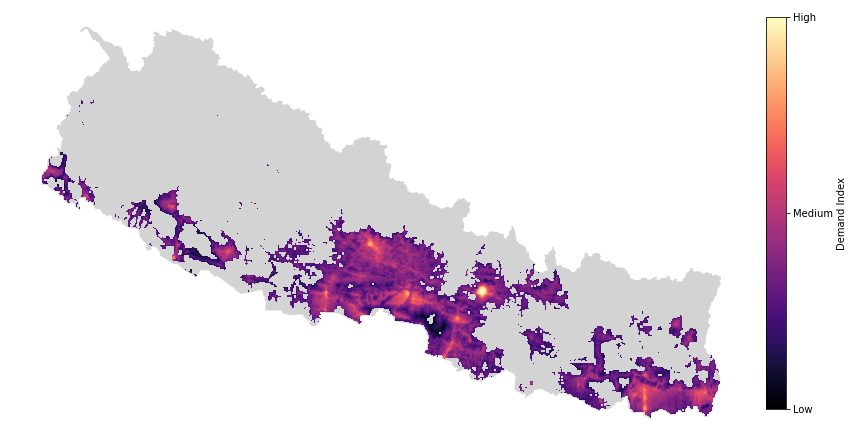

In [171]:
nepal.demand_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                        admin_layer=nepal.mask_layer.layer)

nepal.demand_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                            admin_layer=nepal.mask_layer.layer, dpi=150)

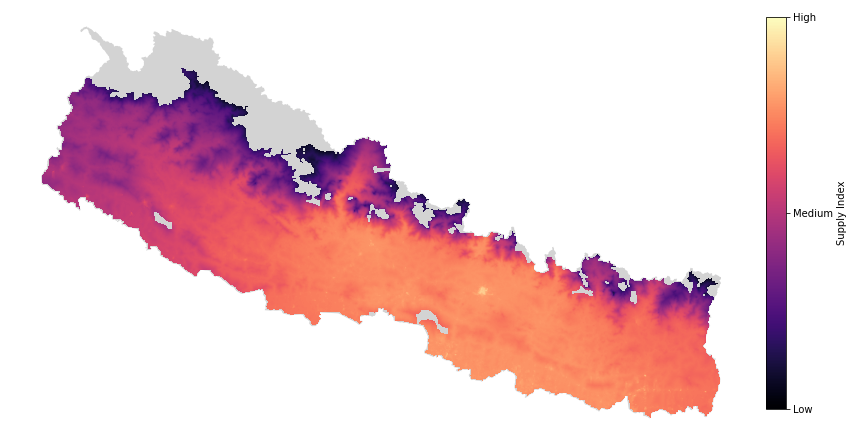

In [172]:
nepal.supply_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                        admin_layer=nepal.mask_layer.layer)

nepal.supply_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                            admin_layer=nepal.mask_layer.layer, dpi=150)

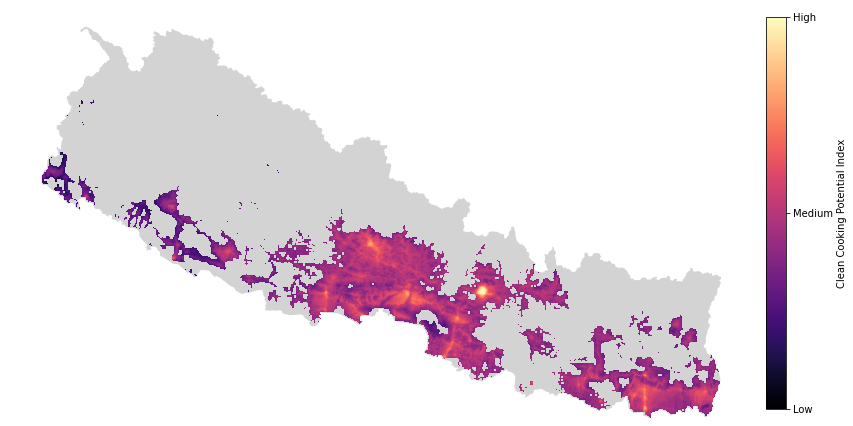

In [173]:
nepal.clean_cooking_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                               admin_layer=nepal.mask_layer.layer)

nepal.clean_cooking_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                   cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                   admin_layer=nepal.mask_layer.layer, dpi=150)

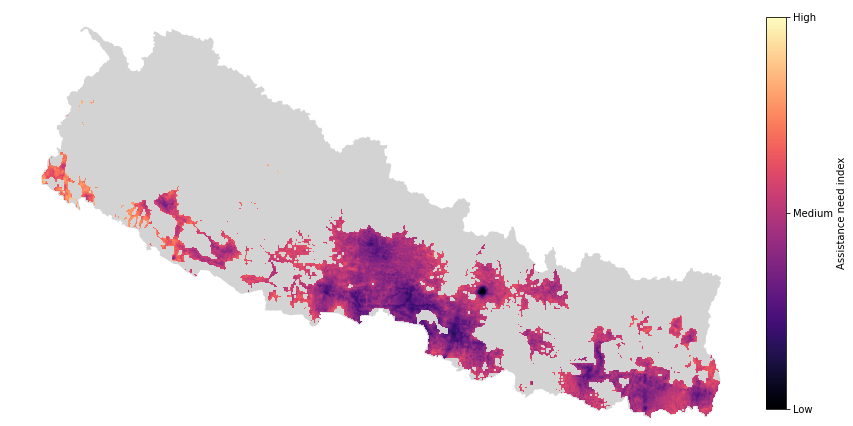

In [176]:
nepal.layers['supply']['LPG dealers'].distance_raster.inverse = False
nepal.layers['demand']['Wealth'].distance_raster.inverse = True
nepal.layers['other']['GDP'].distance_raster.inverse = True
nepal.layers['other']['Roads'].distance_raster.inverse = False


nepal.get_assistance_need_index(datasets={'supply': ['LPG dealers'], 'other': ['Roads', 'GDP'],
                                          'demand': ['Population', 'Wealth', 'Education facilities', 
                                                     'Health facilities', 'Commercial cooking']}, buffer=True)
nepal.assistance_need_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                 admin_layer=nepal.mask_layer.layer)

nepal.assistance_need_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                     cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                     admin_layer=nepal.mask_layer.layer, dpi=150)

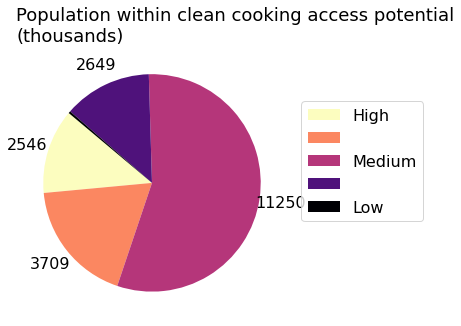

In [177]:
nepal.plot_share(index='Clean Cooking Potential Index', layer=('demand', 'Population'),
                 title='Population within clean cooking access potential', output_file=os.path.join(scenario, 'potential_pop.png'))

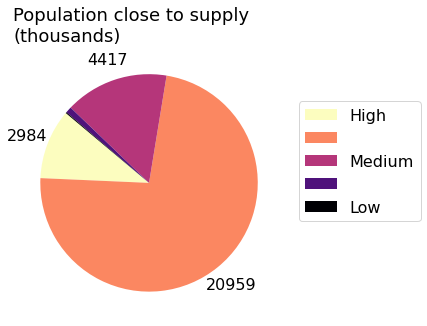

In [178]:
nepal.plot_share(index='Supply Index', layer=('demand', 'Population'),
                 title='Population close to supply', output_file=os.path.join(scenario, 'supply_pop.png'))

## Integrated planning
This scenario explores an integrated energy planning strategy to identify areas where the uptake of clean cooking could be prioritized. First, it identifies areas with various sectoral demands by using population density maps, educational facilities, health facilities and commercial cooking sites. Mixed supply options are considered (LPG, electricity and biogas potential). Moreover, socio-economic data such as wealth index and GDP maps are used to identify willingness to pay.

### Scenario 1
* In this scenario mixed supply options are considered such as LPG, electricity and biogas potential
* In the demand section residential demand (population dataset), education andd health facilities as well as commercial cooking are included.
* GDP and International Wealth Index are also included in order to highlight the areas with lower economic activity.

In [198]:
scenario = 'Integrated planning'

nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = True
nepal.layers['supply']['LPG dealers'].distance_raster.inverse = True
nepal.layers['supply']['Biogas'].distance_raster.inverse = True
nepal.layers['demand']['Wealth'].distance_raster.inverse = False
nepal.layers['other']['GDP'].distance_raster.inverse = False

nepal.layers['supply']['Existent MV lines'].distance_raster.distance_limit = None
nepal.layers['supply']['LPG dealers'].distance_raster.distance_limit = None
nepal.layers['demand']['Education facilities'].distance_raster.distance_limit = None
nepal.layers['demand']['Health facilities'].distance_raster.distance_limit = None
nepal.layers['demand']['Commercial cooking'].distance_raster.distance_limit = None
nepal.layers['demand']['Wealth'].distance_raster.distance_limit = None

nepal.layers['supply']['Existent MV lines'].weight = 2
nepal.layers['supply']['LPG dealers'].weight = 2
nepal.layers['supply']['Biogas'].weight = 1
nepal.layers['demand']['Population'].weight = 2
nepal.layers['demand']['Education facilities'].weight = 1
nepal.layers['demand']['Health facilities'].weight = 1
nepal.layers['demand']['Commercial cooking'].weight = 1
nepal.layers['demand']['Wealth'].weight = 2
nepal.layers['other']['GDP'].weight = 2

nepal.get_demand_index(datasets={'demand': ['Population', 'Education facilities', 
                                            'Health facilities', 'Commercial cooking', 'Wealth']}, buffer=True)
nepal.get_supply_index(datasets={'supply': ['Existent MV lines', 'LPG dealers', 'Biogas'], 'other': ['GDP']}, buffer=True)
nepal.get_clean_cooking_index(buffer=True)

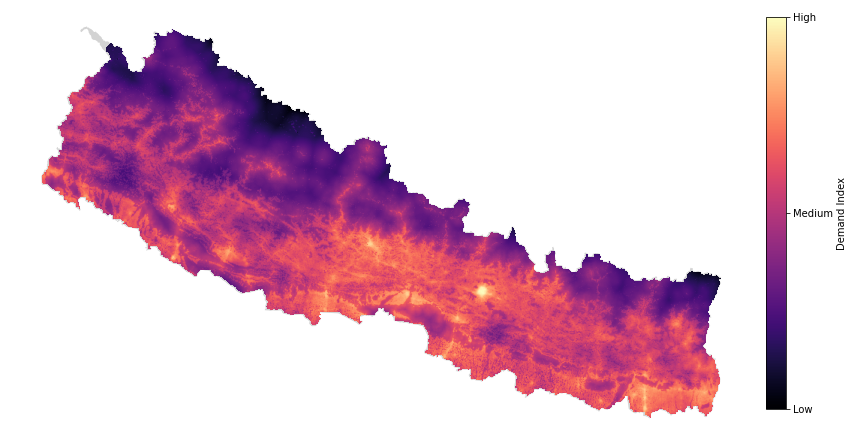

In [199]:
nepal.demand_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'], 
                        admin_layer=nepal.mask_layer.layer)

nepal.demand_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                            admin_layer=nepal.mask_layer.layer)

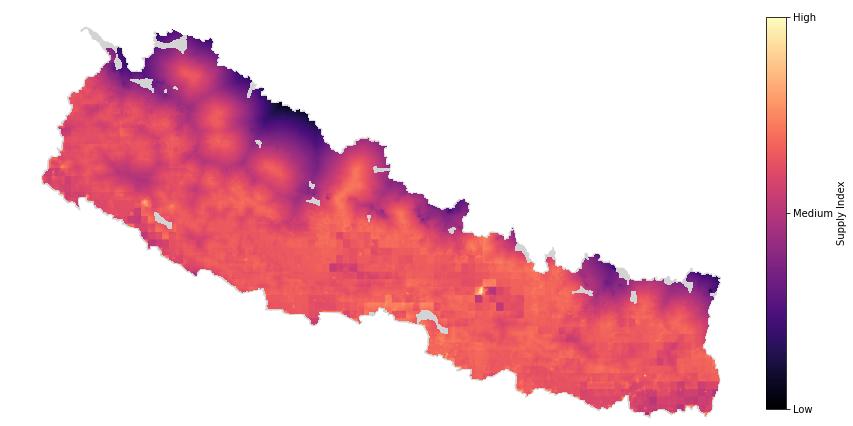

In [200]:
nepal.supply_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                        admin_layer=nepal.mask_layer.layer)

nepal.supply_index.save_png(os.path.join(nepal.output_directory, scenario), 
                            cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                            admin_layer=nepal.mask_layer.layer)

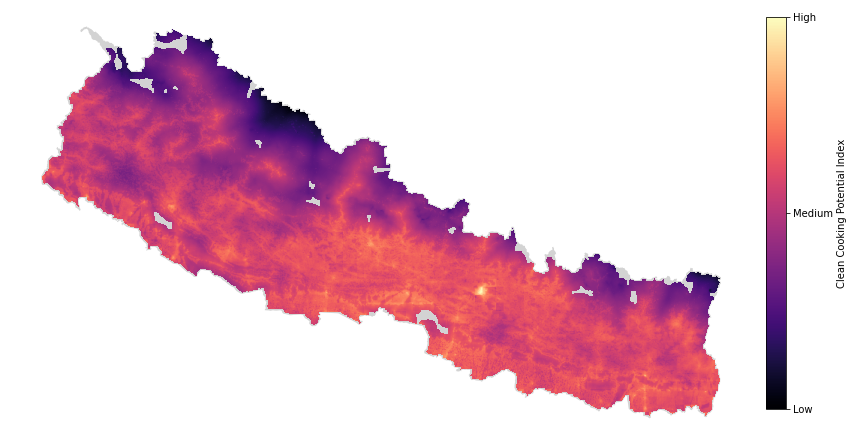

In [201]:
nepal.clean_cooking_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                               admin_layer=nepal.mask_layer.layer)

nepal.clean_cooking_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                   cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                   admin_layer=nepal.mask_layer.layer)

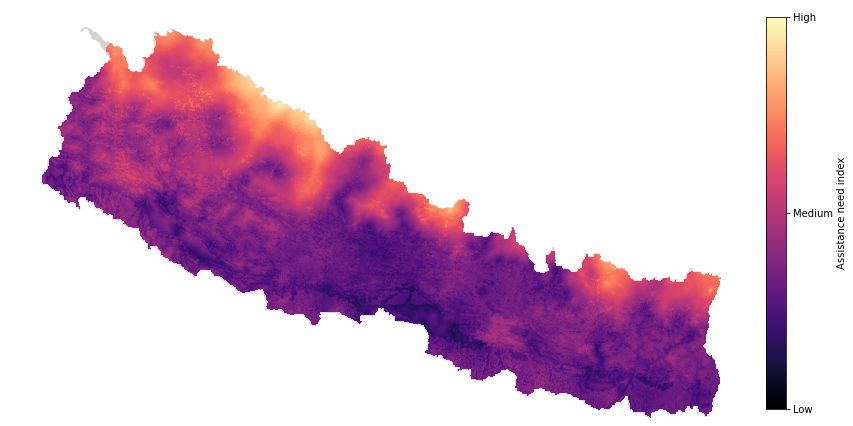

In [206]:
nepal.layers['supply']['Existent MV lines'].distance_raster.inverse = False
nepal.layers['supply']['LPG dealers'].distance_raster.inverse = False
nepal.layers['supply']['Biogas'].distance_raster.inverse = False
nepal.layers['demand']['Wealth'].distance_raster.inverse = True
nepal.layers['other']['GDP'].distance_raster.inverse = True

nepal.get_assistance_need_index(datasets={'supply': ['Existent MV lines', 'LPG dealers'], 'other': ['Roads'],
                                          'demand': ['Population', 'Education facilities', 'Health facilities', 'Wealth']},
                                buffer=True)
nepal.assistance_need_index.plot(cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                 admin_layer=nepal.mask_layer.layer)

nepal.assistance_need_index.save_png(os.path.join(nepal.output_directory, scenario), 
                                     cmap='magma', ticks=[0, 0.5, 1], tick_labels=['Low', 'Medium', 'High'],
                                     admin_layer=nepal.mask_layer.layer, dpi=150)

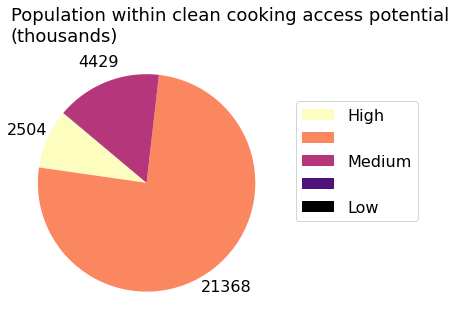

In [208]:
nepal.plot_share(index='Clean Cooking Potential Index', layer=('demand', 'Population'),
                 title='Population within clean cooking access potential', output_file=os.path.join(scenario, 'potential_pop.png'))

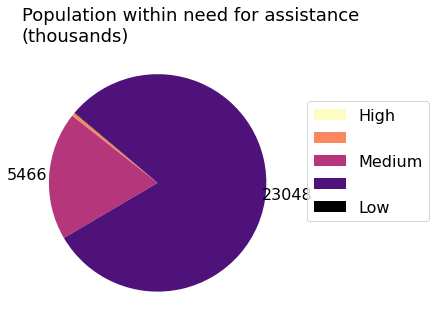

In [207]:
nepal.plot_share(index='Assistance Need Index', layer=('demand', 'Population'),
                 title='Population within need for assistance', output_file=os.path.join(scenario, 'assistance_pop.png'))